In [16]:
import datacube
from datacube.utils import geometry
from datacube.storage import masking
dc = datacube.Datacube()

import numpy as np
import fiona
import rasterio.features
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from shapely.geometry import asShape

import sys
import os
sys.path.append('../other_notebooks/dea-notebooks/10_Scripts')
import DEADataHandling

In [2]:
def geometry_mask(geoms, geobox, all_touched=False, invert=False):
    """
    Create a mask from shapes.

    By default, mask is intended for use as a
    numpy mask, where pixels that overlap shapes are False.
    :param list[Geometry] geoms: geometries to be rasterized
    :param datacube.utils.GeoBox geobox:
    :param bool all_touched: If True, all pixels touched by geometries will be burned in. If
                             false, only pixels whose center is within the polygon or that
                             are selected by Bresenham's line algorithm will be burned in.
    :param bool invert: If True, mask will be True for pixels that overlap shapes.
    """
    data = rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)
    coords = [xr.DataArray(data=coord.values, name=dim, dims=[dim], attrs={'units': coord.units}) 
              for dim, coord in geobox.coords.items()]
    return xr.DataArray(data, coords=coords)

In [3]:
def get_shapes(shape_file):
    with fiona.open(shape_file) as shapes:
        crs = datacube.utils.geometry.CRS(shapes.crs_wkt)
        for shape in shapes:
            geom = datacube.utils.geometry.Geometry(shape['geometry'], crs=crs)
            yield geom, shape['properties']

In [5]:
def fc_polygon_tabulation(shape_file, year_start, year_end):
   #create empty dictionaries and lists 
    annual_dict = {}
    daily_dict = {}
    catchment_list = []
    #create a list of years between the start year and end year specified in the function
    year_list = list(range(year_start,year_end))
    #loop through each calendar year within the year list
    for start_year in year_list:
        end_year = start_year + 1
        print ('Processing '+str(start_year)+' to '+ str(end_year))
        #retrieve all polygons from shapefile
        shapes = get_shapes(shape_file)
        #loop through each polygon within shapefile
        for geometry, properties in shapes:
            #save catchment id from polygon properties as variable 
            catchmentID = 'ID_'+ str(properties['ID'])
            print('Processing catchment '+str(catchmentID))
            #save spatial information from polygon
            geobox = datacube.utils.geometry.GeoBox.from_geopolygon(geometry,
                                                                    [25.0, 25.0], 
                                                                    crs=geometry.crs, 
                                                                    align=None)
            #create timestamp for each calendar year
            start = str(start_year)+'-01-01'
            end  = str(start_year)+'-12-31'
            #create dc query with polygon shapefile
            query = {'geopolygon': geometry,'time':(start, end)}
            #load fc data from datacube for specified year and polygon
            ds = DEADataHandling.load_clearlandsat(dc, 
                                                   query, 
                                                   sensors=('ls5', 'ls7', 'ls8'),
                                                   product='fc',
                                                   masked_prop=0.80)
            #if loaded fc dataset contains data then continue
            if ds.time.size != 0:
                #load a WOfS layer for each timeslice of fc data
                wofls = dc.load(product = 'wofs_albers', like=ds)
             
                #create a mask to remove wet pixels
                wetwofl = masking.make_mask(wofls, wet=True)
                unwofld = ds.where(ds.time == wetwofl.time)
                unwofld = unwofld.where(wetwofl.water==False)
                
                #create a mask to remove data outside of polygon
                mask = geometry_mask([geometry], geobox, all_touched=True, invert=True)
                mask_num = mask *1 #bool to num
                mask_interp =  mask_num.interp_like(ds, method='nearest')#ensure mask and fc data is aligned
                ds_masked = unwofld.where(mask_interp == 1) #mask
                ds_masked.coords['catchment_ID'] = catchmentID #add catchment ID as xr coordinate
                ds_masked['time'] = (ds_masked.time - pd.Timedelta(hours=10)).astype('datetime64[D]') #correct for ls solar day issues
                
                #sum each fc component spatially for each time slice
                bs = ds_masked.BS.sum(dim=('x', 'y')) #bare soil
                pv = ds_masked.PV.sum(dim=('x', 'y')) #photosynthetic vegetation
                npv = ds_masked.NPV.sum(dim=('x', 'y')) #non-photosynthetic vegetation
                ue = ds_masked.UE.sum(dim=('x', 'y')) #unmixing error

                fc_sum = bs + pv + npv + ue #sum all fc components for each time slice

                daily_xr = xr.Dataset({'bs':bs,'pv':pv,'npv':npv,'ue': ue,}) #combine fc into xr dataset
                # caclulate area of each fc component
                annual_area_xr = daily_xr  * (25*25/10_000) 
                annual_area_xr = annual_area_xr.rename({'bs':'bs_area','pv':'pv_area','npv':'npv_area','ue': 'ue_area',})
                #calculate percentage of fc component for each timeslice within polygon
                daily_xr = daily_xr / fc_sum * 100 #calculate percentage
                daily_xr = xr.merge([daily_xr,annual_area_xr]) #join percentage and area xr datasets together
                daily_xr.coords['catchment_ID'] = catchmentID #add catchment ID as coordinate
                if catchmentID not in daily_dict: #search whether ID is in dictionary 
                    daily_dict[catchmentID] = {} #if ID is not in dictionary, create another dictionary
                daily_dict[catchmentID][str(start_year)] = daily_xr #save fc data into dictionary of dictionary

                #sum each fc component spatially for each year
                bs_total = ds_masked.BS.sum(dim=('x', 'y','time'))
                pv_total = ds_masked.PV.sum(dim=('x', 'y','time'))
                npv_total = ds_masked.NPV.sum(dim=('x', 'y','time'))
                ue_total = ds_masked.UE.sum(dim=('x', 'y','time'))
                annual_xr = xr.Dataset({'bs':bs_total,'pv':pv_total,'npv':npv_total,'ue': ue_total,}) #combine annual fc components into xr dataset
                # caclulate area of each annual fc component
                annual_area_xr = annual_xr * (25*25/10_000)
                annual_area_xr = annual_area_xr.rename({'bs':'bs_area','pv':'pv_area','npv':'npv_area','ue': 'ue_area',})
                #calculate percentage of fc component for each year within polygon
                annual_xr = annual_xr /fc_sum.values.sum() * 100 
                annual_xr = xr.merge([annual_xr,annual_area_xr]) #join percentage and area xr datasets together
                annual_xr.coords['catchment_ID'] = catchmentID #add catchment ID as coordinate
                annual_xr.coords['time'] = start #add time (year) as coordinate

                if catchmentID not in annual_dict:  #search whether ID is in dictionary
                    annual_dict[catchmentID] = {} #if ID is not in dictionary, create another dictionary
                annual_dict[catchmentID][str(start_year)] = annual_xr #save fc data into dictionary of dictionary

                print('Catchment '+ str(catchmentID) +' complete')
                print('')
            #if loaded fc dataset does not contain then break current loop
            else:
                break
    #concatenate dictionaries together
    daily_ID_dict = {key: xr.concat(value.values(), dim='time') for key, value in daily_dict.items()} #concatenate dictionary of dates together
    daily_fc_clean = xr.concat(daily_ID_dict.values(),'catchment_ID') #concatenate dictionary of catchment IDs together
    annual_ID_dict = {key: xr.concat(value.values(), dim='time') for key, value in annual_dict.items()} #concatenate dictionary of dates together
    annual_fc_clean = xr.concat(annual_ID_dict.values(),'catchment_ID') #concatenate dictionary of catchment IDs together

    print('Complete')
    return daily_fc_clean, annual_fc_clean #output two xr datasets; daily fc and annual fc

## Use shapefile to return relevant data

In [6]:
# Set this to the location of water body shapefile
shape_file = os.path.expanduser('ACT_Boundary_3577.shp')


#open shapefile and save spatial variables
with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

In [7]:
import warnings
warnings.simplefilter("ignore")

In [8]:
daily_fc_clean, annual_fc_clean = fc_polygon_tabulation(shape_file, 2000, 2002)

Processing 2000 to 2001
Procesing catchment ID_1
    Skipping ls5
Ignoring SLC-off observations for ls7
Loading ls7 PQ
    Loading 12 filtered ls7 timesteps
    Skipping ls8
Combining and sorting ls5, ls7 and ls8 data
Catchment ID_1 complete

Procesing catchment ID_2
    Skipping ls5
Ignoring SLC-off observations for ls7
Loading ls7 PQ
    Loading 13 filtered ls7 timesteps
    Skipping ls8
Combining and sorting ls5, ls7 and ls8 data
Catchment ID_2 complete

Processing 2001 to 2002
Procesing catchment ID_1
    Skipping ls5
Ignoring SLC-off observations for ls7
Loading ls7 PQ
    Loading 4 filtered ls7 timesteps
    Skipping ls8
Combining and sorting ls5, ls7 and ls8 data
Catchment ID_1 complete

Procesing catchment ID_2
    Skipping ls5
Ignoring SLC-off observations for ls7
Loading ls7 PQ
    Loading 6 filtered ls7 timesteps
    Skipping ls8
Combining and sorting ls5, ls7 and ls8 data
Catchment ID_2 complete

Complete


In [10]:
daily_fc_df = daily_fc_clean.dropna(dim='time').to_dataframe().to_csv('daily_fc_df.csv')
annual_fc_df = annual_fc_clean.dropna(dim='time').to_dataframe().to_csv('annual_fc_df.csv')

In [13]:
annual_fc_clean

<xarray.Dataset>
Dimensions:       (catchment_ID: 2, time: 2)
Coordinates:
  * time          (time) <U10 '2000-01-01' '2001-01-01'
  * catchment_ID  (catchment_ID) <U4 'ID_1' 'ID_2'
Data variables:
    bs            (catchment_ID, time) float64 6.808 7.832 5.826 8.021
    pv            (catchment_ID, time) float64 45.82 41.48 45.05 37.88
    npv           (catchment_ID, time) float64 29.69 30.84 33.1 36.52
    ue            (catchment_ID, time) float64 17.68 19.85 16.02 17.58
    bs_area       (catchment_ID, time) float64 2.293e+07 9.037e+06 ... 1.362e+06
    pv_area       (catchment_ID, time) float64 1.544e+08 4.786e+07 ... 6.434e+06
    npv_area      (catchment_ID, time) float64 1e+08 3.558e+07 ... 6.203e+06
    ue_area       (catchment_ID, time) float64 5.955e+07 2.29e+07 ... 2.985e+06

In [ ]:
daily_fc_clean

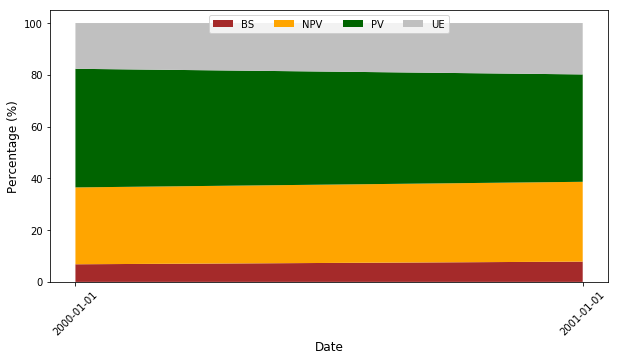

In [14]:
catch_ID = 'ID_1'

fig,ax = plt.subplots(figsize=(10,5))
ax.stackplot(np.asanyarray(annual_fc_clean.sel(catchment_ID = catch_ID).time), 
             np.asanyarray(annual_fc_clean.sel(catchment_ID = catch_ID).bs), 
             np.asanyarray(annual_fc_clean.sel(catchment_ID = catch_ID).npv), 
             np.asanyarray(annual_fc_clean.sel(catchment_ID = catch_ID).pv),
             np.asanyarray(annual_fc_clean.sel(catchment_ID = catch_ID).ue), 
             colors = ['brown','orange','darkgreen','silver'], 
             labels=['BS','NPV','PV','UE'])
plt.legend(loc='upper center', ncol = 4)
plt.ylabel('Percentage (%)', size=12) #Set Y label
plt.xlabel('Date', size=12) #Set X label
plt.xticks(rotation=45)
plt.savefig('annual_fc_cbr_'+str(catch_ID)+'.png')

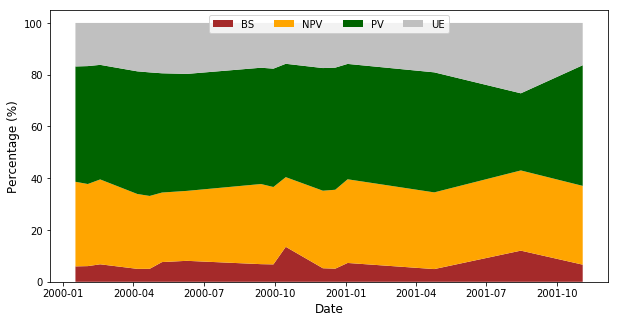

In [15]:
catch_ID = 'ID_1'

fig,ax = plt.subplots(figsize=(10,5))
ax.stackplot(np.asanyarray(daily_fc_clean.dropna(dim='time').sel(catchment_ID = catch_ID).time), 
             np.asanyarray(daily_fc_clean.dropna(dim='time').sel(catchment_ID = catch_ID).bs), 
             np.asanyarray(daily_fc_clean.dropna(dim='time').sel(catchment_ID = catch_ID).npv), 
             np.asanyarray(daily_fc_clean.dropna(dim='time').sel(catchment_ID = catch_ID).pv),
             np.asanyarray(daily_fc_clean.dropna(dim='time').sel(catchment_ID = catch_ID).ue), 
             colors = ['brown','orange','darkgreen','silver'], 
             labels=['BS','NPV','PV','UE'])
plt.legend(loc='upper center', ncol = 4)
plt.ylabel('Percentage (%)', size=12) #Set Y label
plt.xlabel('Date', size=12) #Set X label
plt.savefig('fc_cbr_'+str(catch_ID)+'.png')

In [ ]:
# year_start = 2008
# year_end = 2010


# loaded_xr = {}
# total_dict = {}
# fc_dict = {}
# catchment_list = []

# year_end = year_end + 1
# year_list = list(range(year_start,year_end))

# for start_year in year_list:
#     end_year = start_year + 1
#     print ('Processing '+str(start_year)+' to '+ str(end_year))
#     shapes = get_shapes(shape_file)
#     for geometry, properties in shapes:
#         catchmentID = 'ID_'+ str(properties['ID'])
#         print('Procesing catchment '+str(catchmentID))
#         asShape(geometry)
#         geobox = datacube.utils.geometry.GeoBox.from_geopolygon(geometry,
#                                                                 [25.0, 25.0], 
#                                                                 crs=geometry.crs, 
#                                                                 align=None)
#         start = str(start_year)+'-01-01'
#         end  = str(start_year)+'-12-31'
#         query = {'geopolygon': geometry,'time':(start, end)}
#         ds = DEADataHandling.load_clearlandsat(dc, 
#                                                query, 
#                                                sensors=('ls5', 'ls7', 'ls8'),
#                                                product='fc',
#                                                masked_prop=0.80)
#         if ds.time.size != 0:
#             wofls = dc.load(product = 'wofs_albers', like=ds)
#             wetwofl = masking.make_mask(wofls, wet=True)
#             unwofld = ds.where(ds.time == wetwofl.time)
#             unwofld = unwofld.where(wetwofl.water==False)
#             mask = geometry_mask([geometry], geobox, all_touched=True, invert=True)
#             mask_num = mask *1 #bool to num
#             mask_interp =  mask_num.interp_like(ds, method='nearest')
#             ds_masked = unwofld.where(mask_interp == 1) 
#             ds_masked.coords['catchment_ID'] = catchmentID
#             ds_masked['time'] = (ds_masked.time - pd.Timedelta(hours=10)).astype('datetime64[D]')

#             bs = ds_masked.BS.sum(dim=('x', 'y'))
#             pv = ds_masked.PV.sum(dim=('x', 'y'))
#             npv = ds_masked.NPV.sum(dim=('x', 'y'))
#             ue = ds_masked.UE.sum(dim=('x', 'y'))

#             fc_sum = bs + pv + npv + ue

#             percentage_xr = xr.Dataset({'bs':bs,'pv':pv,'npv':npv,'ue': ue,})
#             percentage_xr = percentage_xr / fc_sum * 100
#             percentage_xr.coords['catchment_ID'] = catchmentID
#             if catchmentID not in fc_dict:
#                 fc_dict[catchmentID] = {}
#             fc_dict[catchmentID][str(start_year)] = percentage_xr


#             bs_total = ds_masked.BS.sum(dim=('x', 'y','time'))/fc_sum.values.sum() * 100
#             pv_total = ds_masked.PV.sum(dim=('x', 'y','time'))/fc_sum.values.sum() * 100
#             npv_total = ds_masked.NPV.sum(dim=('x', 'y','time'))/fc_sum.values.sum() * 100
#             ue_total = ds_masked.UE.sum(dim=('x', 'y','time'))/fc_sum.values.sum() * 100
#             total_xr = xr.Dataset({'bs':bs_total,'pv':pv_total,'npv':npv_total,'ue': ue_total,})
#             total_xr.coords['catchment_ID'] = catchmentID
#             total_xr.coords['time'] = start

#             if catchmentID not in total_dict:
#                 total_dict[catchmentID] = {}
#             total_dict[catchmentID][str(start_year)] = total_xr

#             print('Catchment '+ str(catchmentID) +' complete')
#             print('')
#         else:
#             break

# perc_ID_dict = {key: xr.concat(value.values(), dim='time') for key, value in fc_dict.items()}
# daily_fc_clean = xr.concat(perc_ID_dict.values(),'catchment_ID')

# total_ID_dict = {key: xr.concat(value.values(), dim='time') for key, value in total_dict.items()}
# annual_fc_clean = xr.concat(total_ID_dict.values(),'catchment_ID')

# print('Complete')
# return daily_fc_clean, annual_fc_clean

In [ ]:
# def annual_mean_fc_polygon_percentages(shape_file, year_start, year_end):
#     loaded_xr = {}
#     fc_dict = {}
#     catchment_list = []
#     year_end = year_end + 1
#     year_list = list(range(year_start,year_end))
#     print(year_list)
#     for start_year in year_list:
#         end_year = start_year + 1
#         print ('Processing '+str(start_year)+' to '+ str(end_year))
#         shapes = get_shapes(shape_file)
#         for geometry, properties in shapes:
#             catchmentID = 'ID_'+ str(properties['ID'])
#             print('Procesing catchment '+str(catchmentID))
#             asShape(geometry)
#             geobox = datacube.utils.geometry.GeoBox.from_geopolygon(geometry,
#                                                                     [25.0, 25.0], 
#                                                                     crs=geometry.crs, 
#                                                                     align=None)
#             start = str(start_year)+'-01-01'
#             end  = str(end_year)+'-01-01'
#             query = {'geopolygon': geometry,'time':(start, end)}
#             ds = DEADataHandling.load_clearlandsat(dc, 
#                                                    query, 
#                                                    sensors=('ls5', 'ls7', 'ls8'),
#                                                    product='fc',
#                                                    masked_prop=0.80)
#             if ds.time.size != 0:
#                 wofls = dc.load(product = 'wofs_albers', like=ds)
#                 wetwofl = masking.make_mask(wofls, wet=True)
#                 unwofld = ds.where(ds.time == wetwofl.time)
#                 unwofld = unwofld.where(wetwofl.water==False)
#                 mask = geometry_mask([geometry], geobox, all_touched=True, invert=True)
#                 mask_num = mask *1 #bool to num
#                 mask_interp =  mask_num.interp_like(ds, method='nearest')
#                 ds_masked = unwofld.where(mask_interp == 1) 
#                 ds_masked.coords['catchment_ID'] = catchmentID
#                 ds_masked['time'] = (ds_masked.time - pd.Timedelta(hours=10)).astype('datetime64[D]')

# #                 annual_bs = ds_masked.sum(dim='time')
# #                 print(annual_bs)
#                 bs = ds_masked.BS.sum(dim=('x', 'y'))
#                 pv = ds_masked.PV.sum(dim=('x', 'y'))
#                 npv = ds_masked.NPV.sum(dim=('x', 'y'))
#                 ue = ds_masked.UE.sum(dim=('x', 'y'))

#                 fc_sum = bs + pv + npv + ue

#                 percentage_xr = xr.Dataset({'bs':bs,'pv':pv,'npv':npv,'ue': ue,})
#                 percentage_xr = percentage_xr / fc_sum * 100
#                 percentage_xr.coords['catchment_ID'] = catchmentID
                
#                 catchment_year = str(catchmentID) +'_'+ str(year_start)
#                 fc_dict[catchment_year] = percentage_xr
#                 print(fc_dict)
#                 print('Catchment '+ str(catchmentID) +' complete')
#                 print('')
#             else:
#                 break
#             fc_dict_02 = xr.concat(fc_dict.values(),'catchment_year')
#             print(fc_dict_02)
#     perc_clean = xr.concat(fc_dict_02.values(),'catchment_ID')
#     return perc_clean

In [ ]:
# ID_dict = {key: xr.concat(value.values(), dim='time') for key, value in fc_dict.items()}

In [ ]:
# fc_clean = xr.concat(ID_dict.values(),'catchment_ID')
# fc_clean

In [ ]:
# ([value for key, value in [[value for key, value in fc_dict.items()]]])

In [ ]:
# [value for key, value in fc_dict.items()]

In [ ]:
# xr.concat([value for key, value in [[value for key, value in fc_dict.items()]]])

In [ ]:
# for key, value in fc_dict.items():
#     print (value)

In [ ]:
# ID_1 = xr.concat([value for key, value in fc_dict.items() if key.startswith('ID_1')], 'time')
# ID_2 = xr.concat([value for key, value in fc_dict.items() if key.startswith('ID_2')], 'time')

In [ ]:
# xr.concat([ID_1, ID_2], dim='catchment_ID')

In [ ]:
# xr.concat(fc_dict.values(),'catchment_ID').time


In [ ]:
# def fc_polygon_percentages(shape_file, year_start, year_end):
#     loaded_xr = {}
#     fc_dict = {}
#     catchment_list = []
#     shapes = get_shapes(shape_file)
#     for geometry, properties in shapes:
#         catchmentID = 'ID_'+ str(properties['ID'])
#         print('Procesing catchment '+str(catchmentID))
#         asShape(geometry)
#         geobox = datacube.utils.geometry.GeoBox.from_geopolygon(geometry,
#                                                                 [25.0, 25.0], 
#                                                                 crs=geometry.crs, 
#                                                                 align=None)
#         start = str(year_start)+'-01-01'
#         end  = str(year_end)+'-01-01'
#         query = {'geopolygon': geometry,'time':(start, end)}
#         ds = DEADataHandling.load_clearlandsat(dc, 
#                                                query, 
#                                                sensors=('ls5', 'ls7', 'ls8'),
#                                                product='fc',
#                                                masked_prop=0.80)
#         if ds.time.size != 0:
#             print('Loading wofls')
#             wofls = dc.load(product = 'wofs_albers', like=ds)
#             wetwofl = masking.make_mask(wofls, wet=True)
#             unwofld = ds.where(ds.time == wetwofl.time)
#             unwofld = unwofld.where(wetwofl.water==False)

#             print('Using wofls to mask out water')
#             mask = geometry_mask([geometry], geobox, all_touched=True, invert=True)
#             mask_num = mask *1 #bool to num
#             mask_interp =  mask_num.interp_like(ds, method='nearest')
#             ds_masked = unwofld.where(mask_interp == 1) 
#             ds_masked.coords['catchment_ID'] = catchmentID
#             ds_masked['time'] = (ds_masked.time - pd.Timedelta(hours=10)).astype('datetime64[D]')

#             print('Calculating percentages')
#             bs = ds_masked.BS.sum(dim=('x', 'y'))
#             pv = ds_masked.PV.sum(dim=('x', 'y'))
#             npv = ds_masked.NPV.sum(dim=('x', 'y'))
#             ue = ds_masked.UE.sum(dim=('x', 'y'))

#             fc_sum = bs + pv + npv + ue

#             percentage_xr = xr.Dataset({'bs':bs,'pv':pv,'npv':npv,'ue': ue,})
#             percentage_xr = percentage_xr / fc_sum * 100
#             percentage_xr.coords['catchment_ID'] = catchmentID

#             fc_dict[catchmentID] = percentage_xr
#             print('Catchment '+ str(catchmentID) +' complete')
#             print('')
#         else:
#             break

#     perc_clean = xr.concat(fc_dict.values(),'catchment_ID')
#     return perc_clean

In [ ]:
annual_fc_clean

In [ ]:
perc_clean = fc_polygon_percentages(shape_file,2000,2001)

In [ ]:
perc_clean

In [ ]:
# loaded_xr = {}
# fc_dict = {}
# catchment_list = []
# shapes = get_shapes(shape_file)

# def fc_polygon_percentages():
# for geometry, properties in shapes:
#     catchmentID = 'ID_'+ str(properties['ID'])
#     print('Procesing catchment '+str(catchmentID))
#     asShape(geometry)
#     geobox = datacube.utils.geometry.GeoBox.from_geopolygon(geometry,
#                                                             [25.0, 25.0], 
#                                                             crs=geometry.crs, 
#                                                             align=None)
#     query = {'geopolygon': geometry,'time':(start, end)}
#     ds = DEADataHandling.load_clearlandsat(dc, 
#                                            query, 
#                                            sensors=('ls5', 'ls7', 'ls8'),
#                                            product='fc',
#                                            masked_prop=0.80)
#     if ds.time.size != 0:
#         print('Loading wofls')
#         wofls = dc.load(product = 'wofs_albers', like=ds)
#         wetwofl = masking.make_mask(wofls, wet=True)
#         unwofld = ds.where(ds.time == wetwofl.time)
#         unwofld = unwofld.where(wetwofl.water==False)
        
#         print('Using wofls to mask out water')
#         mask = geometry_mask([geometry], geobox, all_touched=True, invert=True)
#         mask_num = mask *1 #bool to num
#         mask_interp =  mask_num.interp_like(ds, method='nearest')
#         ds_masked = unwofld.where(mask_interp == 1) 
#         ds_masked.coords['catchment_ID'] = catchmentID
#         ds_masked['time'] = (ds_masked.time - pd.Timedelta(hours=10)).astype('datetime64[D]')

#         print('Calculating percentages')
#         bs = ds_masked.BS.sum(dim=('x', 'y'))
#         pv = ds_masked.PV.sum(dim=('x', 'y'))
#         npv = ds_masked.NPV.sum(dim=('x', 'y'))
#         ue = ds_masked.UE.sum(dim=('x', 'y'))
        
#         fc_sum = bs + pv + npv + ue
        
#         percentage_xr = xr.Dataset({'bs':bs,'pv':pv,'npv':npv,'ue': ue,})
#         percentage_xr = percentage_xr / fc_sum * 100
#         percentage_xr.coords['catchment_ID'] = catchmentID
        
#         fc_dict[catchmentID] = percentage_xr
#         print('Catchment '+ str(catchmentID) +' complete')
#         print('')
#     else:
#         break

# perc_clean = xr.concat(fc_dict.values(),'catchment_ID')

In [ ]:
perc_clean.isel(catchment_ID = 0).pv.plot()

In [ ]:
perc_clean.isel(catchment_ID = 1, time = 0)

In [ ]:
df =  pd.DataFrame(ue_list).T
df = pd.DataFrame(df,columns=catchment_list)
df

In [ ]:
loaded_list = pd.DataFrame(columns=['catchment_ID','bs','npv','ue'])
loaded_list

In [ ]:
tabulated = pd.concat([bs_perc,pv_perc,npv_perc,ue_perc],axis=1,)
test

In [ ]:
# loaded_xr = {}
# shapes = get_shapes(shape_file)

# for geometry, properties in shapes:
#     catchmentID = 'ID_'+ str(properties['ID'])
#     print(catchmentID)
#     asShape(geometry)
#     geobox = datacube.utils.geometry.GeoBox.from_geopolygon(geometry,
#                                                             [25.0, 25.0], 
#                                                             crs=geometry.crs, 
#                                                             align=None)
#     query = {'geopolygon': geometry,'time':(start, end)}
#     ds = DEADataHandling.load_clearlandsat(dc, 
#                                            query, 
#                                            sensors=('ls5', 'ls7', 'ls8'),
#                                            product='fc',
#                                            masked_prop=0.80)
#     if ds.time.size != 0:
#         wofls = dc.load(product = 'wofs_albers', like=ds)
#         wetwofl = masking.make_mask(wofls, wet=True)
#         unwofld = ds.where(ds.time == wetwofl.time)
#         unwofld = unwofld.where(wetwofl.water==False)
#         mask = geometry_mask([geometry], geobox, all_touched=True, invert=True)
#         mask_num = mask *1 #bool to num
#         mask_interp =  mask_num.interp_like(ds, method='nearest')
#         ds_masked = unwofld.where(mask_interp == 1) 
#         ds_masked.coords['catchment_ID'] = catchmentID
#         ds_masked['time'] = (ds_masked.time - pd.Timedelta(hours=10)).astype('datetime64[D]')
#         loaded_xr[catchmentID] = ds_masked
#     else:
#         break
        
# fc_clean = xr.concat(loaded_xr.values(),'catchment_ID')
# print(fc_clean)

In [ ]:
test.index

In [ ]:
bs_perc

In [ ]:
# bs = fc_clean.BS.sum(dim=('x', 'y'))
# pv = fc_clean.PV.sum(dim=('x', 'y'))
# npv = fc_clean.NPV.sum(dim=('x', 'y'))
# ue = fc_clean.UE.sum(dim=('x', 'y'))

# fc_sum = bs + pv + npv + ue

# bs_perc = bs/fc_sum * 100
# pv_perc = pv/fc_sum * 100
# npv_perc = npv/fc_sum * 100
# ue_perc = ue/fc_sum * 100

# fc_total = bs_perc +  pv_perc + npv_perc + ue_perc

# ds_perc = bs_perc.to_dataset(dim='BS_perc')
# ds_perc['PV_perc'] = pv_perc
# ds_perc['NPV_perc'] = npv_perc
# ds_perc['UE_perc'] = ue_perc

In [ ]:
bs_perc

In [ ]:
ds_perc

In [ ]:
# #the query is a dictionary where the keys are the spatio-temporal specs
# query = {'geopolygon': geom,
# #         'lat': (-35.25, -35.35),
# #         'lon': (149.05, 149.17),
#         'time':(start, end)
#         }

In [ ]:
# loaded_xr = {}
# for geometry, properties in shapes:
#     geobox = datacube.utils.geometry.GeoBox.from_geopolygon(geometry, hi_resolution, crs, align)
#     data = dc.load(product=product_id, 
#                measurement=measurement_id, 
#                datasets=datasets, 
#                dask_chunks={'time': 1}, 
#                geopolygon=geometry,
#                resolution=hi_resolution,)
#                #output_crs='EPSG:32648')
#     SCID = properties['ID_RB']
#     print(SCID)
#     mask = geometry_mask([geometry], geobox, all_touched=True, invert=True)
#     rain_array = data.PET.where(data.PET > -1).where(mask)
#     #rain_array = data.spei_gamma_03.where(data.spei_gamma_03 > -3.1).where(mask)
#     loaded = rain_array.mean(dim=['latitude', 'longitude']).load();
#     loaded_xr[SCID] = loaded
# print(loaded_xr)


In [ ]:
# data = dc.load(product=f'{sensor}_{product}_albers',
#                                group_by='solar_day', 
#                                dask_chunks={'time': 1},
#                                **query)
#  # Load PQ data
# pq = dc.load(product=f'{sensor}_pq_albers',
#              group_by='solar_day',
#              fuse_func=ga_pq_fuser,
#              dask_chunks={'time': 1},
#              **query)

# if not ls7_slc_off and sensor == 'ls7':
#     print('Ignoring SLC-off observations for ls7')
#     data = data.sel(time=data.time < np.datetime64('2003-05-30'))
# time = (data.time - pq.time).time
# data = data.sel(time=time)
# pq = pq.sel(time=time)

# # Load PQ data using dask
# print('Loading {} pixel quality'.format(sensor))
# pq = pq.compute()

# # Identify pixels with no clouds in either ACCA for Fmask
# good_quality = masking.make_mask(pq.pixelquality,
#                                  cloud_acca='no_cloud',
#                                  cloud_fmask='no_cloud',
#                                  contiguous=True)

In [ ]:
# wetwofl = masking.make_mask(wofls, wet=True)
# unwofld = ds.where(ds.time == wetwofl.time)
# unwofld = unwofld.where(wetwofl.water==False)

In [ ]:
# resolution = [25.0, 25.0]
# shapes = get_shapes(shape_file)

# for geometry, properties in shapes:
#         geobox = datacube.utils.geometry.GeoBox.from_geopolygon(geometry, resolution, crs=geometry.crs, align=None)
#         mask = geometry_mask([geometry], geobox, all_touched=True, invert=True)
#         mask_num = mask *1 #bool to num
#         mask_interp =  mask_num.interp_like(ds, method='nearest')
#         ds_masked = unwofld.where(mask_interp == 1) 
        

# ##with multiple polygons in a shapefile, need to save out as xr dataset with polygon ID

In [ ]:
ds_perc.sel(catchment_ID = 'ID_1')

In [ ]:
# bs = ds_masked.BS.sum(dim=('x', 'y'))
# pv = ds_masked.PV.sum(dim=('x', 'y'))
# npv = ds_masked.NPV.sum(dim=('x', 'y'))
# ue = ds_masked.UE.sum(dim=('x', 'y'))

# fc_sum = bs + pv + npv + ue

# bs_perc = bs/fc_sum * 100
# pv_perc = pv/fc_sum * 100
# npv_perc = npv/fc_sum * 100
# ue_perc = ue/fc_sum * 100

# fc_total = bs_perc +  pv_perc + npv_perc + ue_perc

# ds_perc = bs_perc.to_dataset(dim='BS_perc')
# ds_perc['PV_perc'] = pv_perc
# ds_perc['NPV_perc'] = npv_perc

# ds_perc['UE_perc'] = ue_perc

In [ ]:
# ds_perc.BS_perc.plot()

In [ ]:
rgb_ds = fc_clean.isel(time =0).sel(catchment_ID = 'ID_2').to_array(dim='color').sel(color=['BS','PV','NPV']).transpose('y', 'x', 'color')
rgb_ds = rgb_ds.astype('double')
max_val = rgb_ds.max(['y', 'x'])
scaled = (rgb_ds / max_val)

plt.imshow(scaled)

In [ ]:
ds_perc.sel(catchment_ID = 'ID_1')

In [ ]:
# ds_perc = ds_perc.sel(catchment_ID = '2')

In [ ]:
np.asanyarray(ds_perc.sel(catchment_ID = 'ID_1').time)

In [ ]:
catch_ID = 'ID_3'

In [ ]:
# bs_perc = bs/fc_sum * 100
# pv_perc = pv/fc_sum * 100
# npv_perc = npv/fc_sum * 100
# ue_perc = ue/fc_sum * 100

In [ ]:
fc_total = bs_perc +  pv_perc + npv_perc + ue_perc

In [ ]:
# print(bs_perc)
# print(pv_perc)
# print(npv_perc)
# print(ue_perc)

In [ ]:
plt.imshow(scaled)

In [ ]:
# wetwofl = masking.make_mask(wofls, wet=True)
# unwofld = ds_masked.where(ds_masked.time == wetwofl.time)
# unwofld = unwofld.where(wetwofl.water==False)


In [ ]:
loaded_xr = {}
fc_dict = {}
catchment_list = []
shapes = get_shapes(shape_file)

for geometry, properties in shapes:
    catchmentID = 'ID_'+ str(properties['ID'])
    print('Procesing catchment '+str(catchmentID))
    asShape(geometry)
    geobox = datacube.utils.geometry.GeoBox.from_geopolygon(geometry,
                                                            [25.0, 25.0], 
                                                            crs=geometry.crs, 
                                                            align=None)
    query = {'geopolygon': geometry,'time':(start, end)}
    ds = DEADataHandling.load_clearlandsat(dc, 
                                           query, 
                                           sensors=('ls5', 'ls7', 'ls8'),
                                           product='fc',
                                           masked_prop=0.80)
    if ds.time.size != 0:
        print('Loading wofls')
        wofls = dc.load(product = 'wofs_albers', like=ds)
        wetwofl = masking.make_mask(wofls, wet=True)
        unwofld = ds.where(ds.time == wetwofl.time)
        unwofld = unwofld.where(wetwofl.water==False)
        print('Using wofls to mask out water')
        mask = geometry_mask([geometry], geobox, all_touched=True, invert=True)
        mask_num = mask *1 #bool to num
        mask_interp =  mask_num.interp_like(ds, method='nearest')
        ds_masked = unwofld.where(mask_interp == 1) 
        ds_masked.coords['catchment_ID'] = catchmentID
        ds_masked['time'] = (ds_masked.time - pd.Timedelta(hours=10)).astype('datetime64[D]')
#         print(ds_masked)
#         loaded_xr[catchmentID] = ds_masked
#         print(loaded_xr)
        print('Calculating percentages')
        bs = ds_masked.BS.sum(dim=('x', 'y'))
        pv = ds_masked.PV.sum(dim=('x', 'y'))
        npv = ds_masked.NPV.sum(dim=('x', 'y'))
        ue = ds_masked.UE.sum(dim=('x', 'y'))
        
        fc_sum = bs + pv + npv + ue
        
        percentage_xr = xr.Dataset({'bs':bs,'pv':pv,'npv':npv,'ue': ue,})
        percentage_xr = percentage_xr / fc_sum * 100
        percentage_xr.coords['catchment_ID'] = catchmentID
        
        fc_dict[catchmentID] = percentage_xr
        print('Catchment '+ str(catchmentID) +' complete')
        print('')
    
#         bs_perc = (bs/fc_sum * 100)#.to_pandas().T#.to_dataframe(name='bs')        
#         pv_perc = (pv/fc_sum * 100)#.to_pandas().T#.to_dataframe(name='pv')#.drop(columns=['catchment_ID'])
#         npv_perc = (npv/fc_sum * 100)#.to_pandas().T#.to_dataframe(name='npv')#.drop(columns=['catchment_ID'])
#         ue_perc = (ue/fc_sum * 100)#.to_pandas().T#.to_dataframe(name='ue')#.drop(columns=['catchment_ID'])
# #         ue_perc = ue_perc.to_pandas()
        
        
#         ue_dict[catchmentID] = ue_perc
        
#         tabulated = pd.concat([bs_perc,pv_perc,npv_perc,ue_perc],axis=1)
#         loaded_df.append(tabulated)
        
#         test = pd.concat([bs_perc,pv_perc,npv_perc,ue_perc])
#         print(test)
        
        
#         fc_total = bs_perc +  pv_perc + npv_perc + ue_perc
        
#         loaded_list.append([catchmentID,bs_perc,pv_perc,npv_perc,ue_perc,fc_total])
    else:
        break

perc_clean = xr.concat(fc_dict.values(),'catchment_ID')

# cols = ['ID','BS','PV','NPV','UE','summed_perc']
# fc_df = pd.DataFrame(columns=cols,data=loaded_list)